This assignment is about stars...

We will work with a star catalogue of 240 stars described by the following information:

- Temperature (in Kelvin)
- Luminosity (L/Lo)
- Radius (R/Ro)
- Absolute magnitude (Mv)

We also have the following data for each star:

- Color (Red/Orange/Yellow/White/Blue)
- Spectral class ('A', 'B', 'F', 'G', 'K', 'M', 'O')
- Star type (Brown dwarf/Red dwarf/White dwarf/Main sequence/Supergiant/Hypergiant)

This dataset has been collected by [Deepraj Baidya](https://github.com/deepraj1729) and was originally published on [Kaggle](https://www.kaggle.com/deepu1109/star-dataset). 


There are 6 star types that are encoded in the 'Star type' column. These labels are currently encoded as strings which is practical for reading but not for computing. Using scikit-learn, we will convert this column into integers by assigning a unique int value to each star type.

Star classification is something that can be done based on rules depending on temperature and luminosity. For example, Wikipedia gives the following example of a Hertzsprung-Russell diagram:
![](https://upload.wikimedia.org/wikipedia/commons/6/6b/HRDiagram.png)

In [1]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import random
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/nshaud/ml_for_astro/main/stars.csv", "stars.csv")

('stars.csv', <http.client.HTTPMessage at 0x133c42e90>)

In [3]:
import pandas as pd
df_stars = pd.read_csv("stars.csv")

In [4]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
# Assign unique integers from 0 to 6 to each star type
df_stars['Star type'] = le.fit_transform(df_stars['Star type'])
labels = le.inverse_transform(df_stars['Star type'])
class_names = le.classes_
print(class_names)

['Brown Dwarf' 'Hypergiant' 'Main Sequence' 'Red Dwarf' 'Supergiant'
 'White Dwarf']


We've seen this already last time. It is often grood practice to start with a statistical analysis of the dataset to answer the following questions:
* are there any missing values?
* are there NaNs in the data?

In [5]:
#Check and in case remove NaN values
T_dirty = df_stars['Temperature (K)']
L_dirty = df_stars['Luminosity(L/Lo)']
R_dirty = df_stars['Radius(R/Ro)']
AM_dirty = df_stars['Absolute magnitude(Mv)']

T = T_dirty[~np.isnan(T_dirty)]
R = R_dirty[~np.isnan(R_dirty)]
L = L_dirty[~np.isnan(L_dirty)]
AM = AM_dirty[~np.isnan(AM_dirty)]

## HR diagram

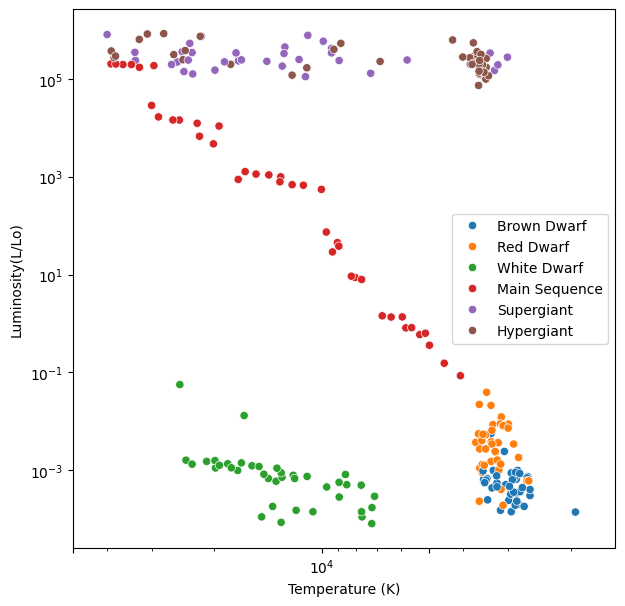

In [6]:
import seaborn as sns

fig = plt.figure(figsize=(7, 7))
sns.scatterplot(data=df_stars, x='Temperature (K)', y='Luminosity(L/Lo)', hue=labels)

plt.xscale('log')
plt.yscale('log')
plt.xticks([5000, 10000, 50000])
plt.xlim(5e4, 1.5e3)
plt.show()

We find the same organization of stars in this 2D plane. Main Sequence stars and White Dwarves are fairly easy to isolate from the rest: a statistical model should be able to easily classify them. Based only on Luminosity and Temperature, Dwarf stars and Giant stars have higher intra-group variability: Supergiant and Hypergiant cover the same space (same for Brown and Red Dwarves). Additionnal variables might be needed to correctly identify the types of those stars.

Apply PCA to the dataset at your disposal (hint: don't use columns with labels, only those with real numbers).
Project the dataset into the principal components, and do a scatter plot of the first two.
This will look terrible. Think about the units!
Explore what happens if you rescale the data first.
This is actually a very important lesson in machine learning: Massaging your data before giving them to an algorithm can make things much much better.

You can try an linear, affine transformation such that each dimension goes between -1 and 1.
Or (which is the usual machine-learning approach) standardize your data such that each dimension has mean=0 and variance=1.
Redo your PCA. Should be much much better.
How much variance is explained by those two components?

In [7]:
#Project the dataset into the principal components, and do a scatter plot of the first two.
#Think about the units! Explore what happens if you rescale the data first. 


np.random.seed(4)
nrows = len(df_stars['Temperature (K)'])
n_components = 4 

pca = PCA(n_components=n_components)
pca.fit(df_stars.iloc[:, :4]) #take only the first 5 col to avoid strings
stars_transformed = pca.transform(df_stars.iloc[:, :4]) 

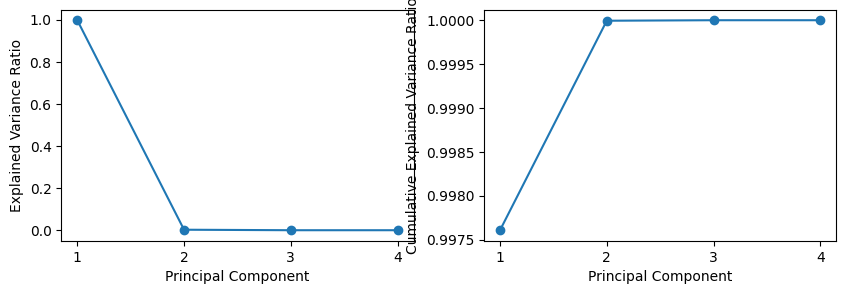

In [8]:
evals = pca.explained_variance_ratio_
# Plot the results

fig = plt.figure(figsize=(10, 3))

ax = fig.add_subplot(121)

ax.plot(range(1, n_components+1), evals)
ax.scatter(range(1, n_components+1), evals)

ax.set_xlabel("Principal Component")  # ✅ CORRETTO
ax.set_ylabel("Explained Variance Ratio")
ax.set_xticks(range(1, n_components+1))

ax = fig.add_subplot(122)

ax.plot(range(1, n_components+1), evals.cumsum())
ax.scatter(range(1, n_components+1), evals.cumsum())

ax.set_xlabel("Principal Component")  # ✅ CORRETTO
ax.set_ylabel("Cumulative Explained Variance Ratio")
ax.set_xticks(range(1, n_components+1))

plt.show()


In [9]:
print("The first component explains {:.3f} of the variance in the data.".format(pca.explained_variance_ratio_[0]))
print("The second component explains {:.3f} of the variance in the data.".format(pca.explained_variance_ratio_[1]))

The first component explains 0.998 of the variance in the data.
The second component explains 0.002 of the variance in the data.


with the first two components I can explain almost 100% of the variance


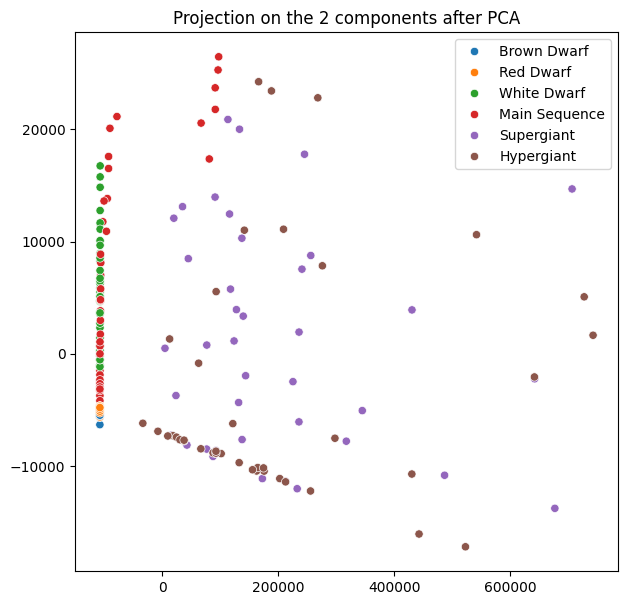

In [10]:
fig = plt.figure(figsize=(7, 7))
sns.scatterplot(x=stars_transformed[:,0], y=stars_transformed[:,1], hue=labels)
plt.title('Projection on the 2 components after PCA')
plt.show()


## Standard Scaler to rescale the data before doing PCA

In [16]:
from sklearn.preprocessing import StandardScaler #By scaling, we ensure that all features contribute equally to the analysis.

X = df_stars.iloc[:, :4]
scaler = StandardScaler().set_output(transform="pandas") #Standardization transforms the data so that each feature (column) has a mean of 0 and a standard deviation of 1.
scaled_X = scaler.fit_transform(X) #Each feature (column) is standardized using the formula: (x - mean) / standard deviation.
 

In [22]:
pca = PCA()
pca.fit(X)
eigenvalues = pca.transform(X)
mean = pca.mean_ 
eigenvectors = pca.components_ 
evals = pca.explained_variance_ratio_ 

for idx, r in enumerate(evals):
    print(f'Comp {idx+1} - variance explained : {100*r:.2f} - cumulative : {evals.cumsum()[idx]*100}')


# Reconstruction of object1
# Xreconstruct[0] = mean + eigenvectors*eigenvalues[0]

#print("new shape:", eigenvalues.shape)
#print(eigenvectors.shape)

#print('Explained fractional variance of data encapsulated in the eigenvalues: ' + str(evals), "\nsum: ", np.sum(evals))
print()

scaled_pca = PCA()
scaled_pca.fit(scaled_X)
scaled_eigenvalues = scaled_pca.transform(scaled_X)
scaled_mean = scaled_pca.mean_ 
scaled_eigenvectors = scaled_pca.components_ 
scaled_evals = scaled_pca.explained_variance_ratio_ 

for idx, r in enumerate(scaled_evals):
    print(f'Comp {idx+1} - variance explained : {100*r:.2f} - cumulative : {scaled_evals.cumsum()[idx]*100}')

# Reconstruction of object1
# Xreconstruct[0] = mean + eigenvectors*eigenvalues[0]

#print("new shape:", scaled_eigenvalues.shape)
#print(scaled_eigenvectors.shape)

#print('Explained fractional variance of data encapsulated in the scaled eigenvalues: ' + str(scaled_evals), "\nsum: ", np.sum(scaled_evals))


Comp 1 - variance explained : 99.76 - cumulative : 99.76063126866043
Comp 2 - variance explained : 0.24 - cumulative : 99.99942118846565
Comp 3 - variance explained : 0.00 - cumulative : 99.99999986572581
Comp 4 - variance explained : 0.00 - cumulative : 100.0

Comp 1 - variance explained : 60.36 - cumulative : 60.35739091573399
Comp 2 - variance explained : 23.50 - cumulative : 83.85817508043479
Comp 3 - variance explained : 9.33 - cumulative : 93.18782024519136
Comp 4 - variance explained : 6.81 - cumulative : 100.0


Text(0, 0.5, 'Second Principal Component')

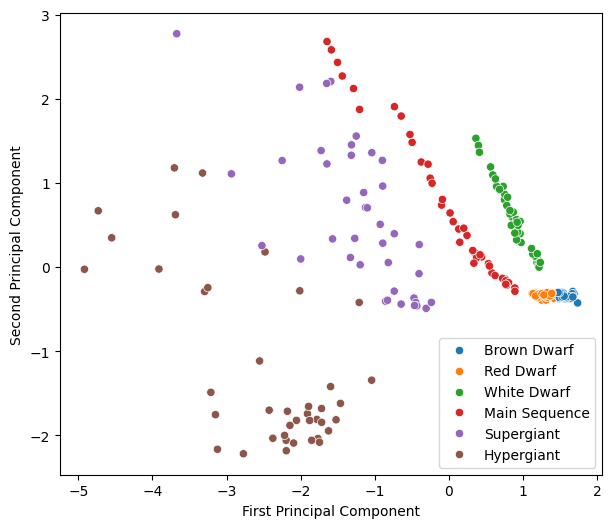

In [20]:
fig = plt.figure(figsize=(7, 6))
sns.scatterplot( x = scaled_eigenvalues[:,0], y= scaled_eigenvalues[:,1], hue=labels)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')


Quando si applica la è importante standardizzare i dati, altrimenti le variabili con scale diverse possono dominare la varianza totale.

---

# Standardizzazione

La standardizzazione trasforma ogni variabile $x$ in una nuova variabile $z$:

$$
z = \frac{x - \mu}{\sigma}
$$

dove:
- $\mu$ è la media della variabile,
- $\sigma$ è la deviazione standard.

Dopo questa trasformazione:
- la **media** diventa $0$,
- la **varianza** diventa $1$.

---


- **Senza standardizzazione**: una variabile con valori molto grandi può spiegare quasi tutta la varianza (anche il **99%**).  
- **Con standardizzazione**: tutte le variabili hanno la stessa scala e una varianza iniziale pari a $1$, quindi le componenti principali spiegano la varianza in modo più equilibrato.